# 8-point Algo

In [2]:
# Imports
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# Constants
MIN_MATCH_COUNT = 8

## Find Keypoints and Match with RANSAC

### Find keypoints and descriptors

In [3]:
def find_keypoints_and_descriptors(image_gray, detector = cv2.ORB_create(3000)):
    '''Detect keypoints in a greyscale image'''
    keypoints, descriptors = detector.detectAndCompute(image_gray, None)
    return keypoints, descriptors


### Match Points

In [4]:
# Find good matches between two sets of descriptors
def match_descriptors(des1, des2):
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1, des2, k=2)
    good_matches = []
    for m, n in matches:
        if m.distance < 0.8 * n.distance:
            good_matches.append(m)
    return good_matches


### Find inliers of matches

In [5]:
def find_homography_and_draw_matches(im1_gray, im2_gray, kp1, kp2, good_matches):
    '''Find homography between two images given the keypoints'''
    if len(good_matches) > MIN_MATCH_COUNT:
        src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
        matchesMask = mask.ravel().tolist()
    else:
        print("Not enough matches are found - {}/{}".format(len(good_matches), MIN_MATCH_COUNT))
        matchesMask = None
    
    inlier_pts1 = np.float32([kp1[m.queryIdx].pt for i, m in enumerate(good_matches) if matchesMask[i]])
    inlier_pts2 = np.float32([kp2[m.trainIdx].pt for i, m in enumerate(good_matches) if matchesMask[i]])
    
    return inlier_pts1, inlier_pts2

### Find inlier matching points between 2 images

In [6]:
def find_inlier_matching_points(im1_gray, im2_gray):
    '''Function to find inlier matching points between two images'''
    # Find the key points and descriptors in the two images
    kp1, des1 = find_keypoints_and_descriptors(im1_gray)
    kp2, des2 = find_keypoints_and_descriptors(im2_gray)

    # Match keypoints
    good_matches = match_descriptors(des1, des2)

    # Find homography and draw matches
    #inlier_pts1, inlier_pts2 = find_homography_and_draw_matches(im1_gray, im2_gray, kp1, kp2, good_matches)
    inlier_pts1 = np.float32([kp1[m.queryIdx].pt for i, m in enumerate(good_matches)])
    inlier_pts2 = np.float32([kp2[m.trainIdx].pt for i, m in enumerate(good_matches)])
    return inlier_pts1, inlier_pts2

In [7]:
def plot_two_images_with_matches(im1, im2, inlier_pts1, inlier_pts2):
    '''Plot two images side by side with matches shown'''
    # Convert grayscale images to BGR so that we can draw colored lines
    im1_color = cv2.cvtColor(im1, cv2.COLOR_GRAY2BGR)
    im2_color = cv2.cvtColor(im2, cv2.COLOR_GRAY2BGR)

    img3 = np.hstack((im1_color, im2_color))
    for pt1, pt2 in zip(inlier_pts1, inlier_pts2):
        pt2 = (pt2[0] + im1.shape[1], pt2[1])
        cv2.line(img3, tuple(map(int, pt1)), tuple(map(int, pt2)), (0, 255, 0), 1)
        cv2.circle(img3, tuple(map(int, pt1)), 5, (0, 0, 255), -1)
        cv2.circle(img3, tuple(map(int, pt2)), 5, (0, 0, 255), -1)


    # Show the matches image
    plt.figure()
    plt.imshow(cv2.cvtColor(img3, cv2.COLOR_BGR2RGB))
    plt.show()

### Show feature matches

c:\Users\Home\Documents\GitHub\Comp558Project\8PointAlgorithm\Reference_Render_cubes\Reference_Render_Translation


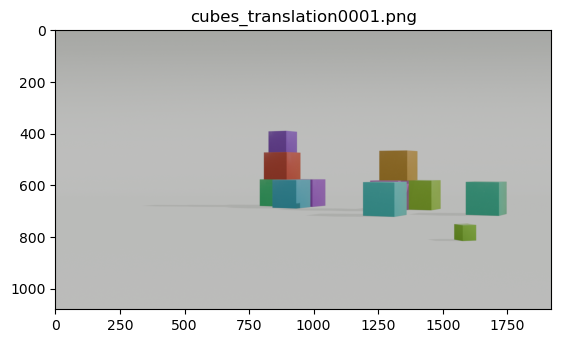

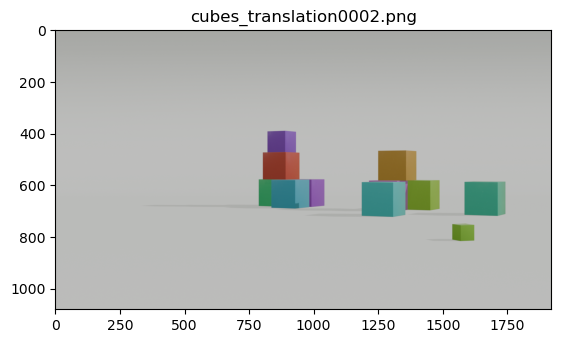

In [68]:
# load images
absolute_folder_path = os.path.join(os.getcwd(), 'Reference_Render_cubes', 'Reference_Render_Translation')
print(absolute_folder_path)
im1_name = 'cubes_translation0001.png'
im1 = cv2.imread(os.path.join(absolute_folder_path,im1_name))
im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2RGB)


plt.title(im1_name)
a = plt.imshow(im1)
plt.show()

im2_name = 'cubes_translation0002.png'
im2 = cv2.imread(os.path.join(absolute_folder_path,im2_name), 3)
im2 = cv2.cvtColor(im2, cv2.COLOR_BGR2RGB)
plt.title(im2_name)
a = plt.imshow(im2)
plt.show()

# Convert images to grayscale
im1_gray = cv2.cvtColor(im1, cv2.COLOR_RGB2GRAY)
im2_gray = cv2.cvtColor(im2, cv2.COLOR_RGB2GRAY)

# Plot 

c:\Users\Home\Documents\GitHub\Comp558Project\8PointAlgorithm\Reference_Render_cubes\Class_Room


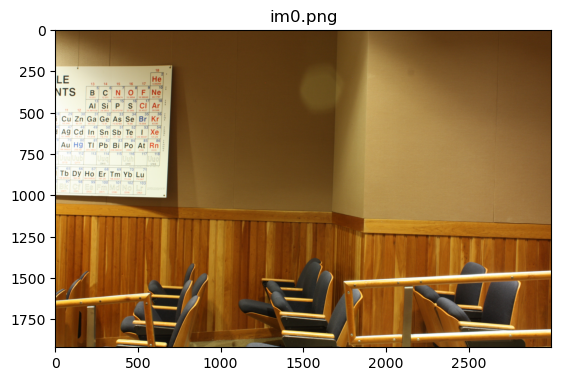

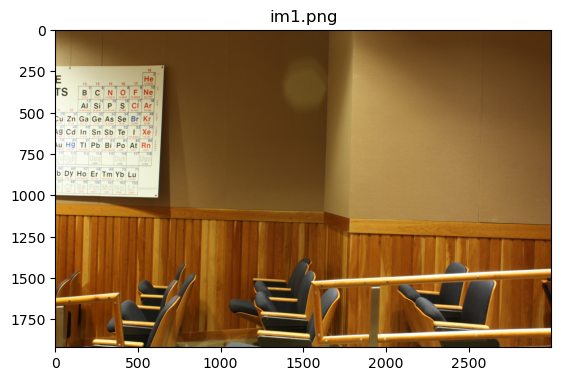

In [9]:
# load images
absolute_folder_path = os.path.join(os.getcwd(), 'Reference_Render_cubes', 'Class_Room')
print(absolute_folder_path)
im1_name = 'im0.png'
im1 = cv2.imread(os.path.join(absolute_folder_path,im1_name))
im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2RGB)


plt.title(im1_name)
a = plt.imshow(im1)
plt.show()

im2_name = 'im1.png'
im2 = cv2.imread(os.path.join(absolute_folder_path,im2_name), 3)
im2 = cv2.cvtColor(im2, cv2.COLOR_BGR2RGB)
plt.title(im2_name)
a = plt.imshow(im2)
plt.show()

# Convert images to grayscale
im1_gray = cv2.cvtColor(im1, cv2.COLOR_RGB2GRAY)
im2_gray = cv2.cvtColor(im2, cv2.COLOR_RGB2GRAY)

# Plot 

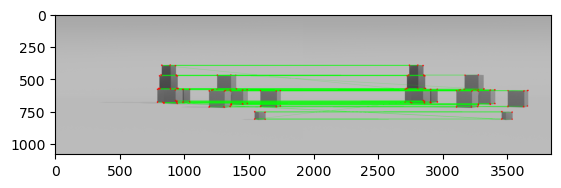

Number of matching points found: 255


In [69]:

# Compute points
pts1, pts2 = find_inlier_matching_points(im1_gray, im2_gray)

# Plot the inlier matching points
plot_two_images_with_matches(im1_gray, im2_gray, pts1, pts2)

print(f"Number of matching points found: {len(pts1)}")


## Compute the fundamental matrix

In [70]:
def compute_normalization_matrix(pts):
    """Computes the normalization matrix for the points. Assumes x,y and shape (N x 2)"""    
    # Normalize points
    pts1_mean = np.mean(pts, axis=0)
    
    pts1_std = np.std(pts) # TODO: Computes flattened std. Need to instead compute as seen in the lecture slides (https://stackoverflow.com/questions/52940822/what-is-the-correct-way-to-normalize-corresponding-points-before-estimation-of-f)
    T = np.array([[1/pts1_std, 0, -pts1_mean[0]/pts1_std],
                [0, 1/pts1_std, -pts1_mean[1]/pts1_std],
                [0, 0, 1]])
    return T
    

### Compute Fundamental Matrix

In [12]:
def compute_fundamental_matrix(pts1, pts2):
    return cv2.findFundamentalMat(pts1, pts2, cv2.RANSAC)

### Compute Essential matrix

In [13]:
def compute_essential_matrix(pts1, pts2, K):
    return cv2.findEssentialMat(pts1, pts2, K, cv2.RANSAC)

Test compute E and F

In [71]:
# Define Intrinsic Matrix
K = np.array([[2666.666666666, 0, 960],
            [0, 2666.666666666, 540],
            [0, 0, 1]]) 
F, mask = compute_fundamental_matrix(pts1, pts2)
norm = np.linalg.norm(F)
F /= norm
print(F.shape)
E = np.matmul(np.matmul(K.T, F), K)
norm = np.linalg.norm(E)
E /= norm

E_prime, mask = compute_essential_matrix(pts1, pts2, K)
norm = np.linalg.norm(E_prime)
E_prime /= norm

print(f"E from fund = {E}")
print(f"E from direct = {E_prime}")

(3, 3)


TypeError: compute_essential_matrix() takes 2 positional arguments but 3 were given

In [15]:
from helper import apply_matrix
# Plot transformed points
F, mask = compute_fundamental_matrix(pts1, pts2)
print(mask)
transformed_pts = apply_matrix(pts1, F)

print(transformed_pts)

plt.title(im2_name)
a = plt.imshow(im2)
plt.scatter(x=pts2[:,0], y=pts2[:,1], c='r', label = "Base feature points")
plt.scatter(x=transformed_pts[:,0], y=transformed_pts[:,1], c='g', label ="Transformed feature points")
plt.legend(loc="upper left")
plt.show()

ModuleNotFoundError: No module named 'helper'

## Essential Matrix

In [75]:
def compute_essential_matrix(F, K):
    '''Recover essential matrix from fundamental matrix and camera intrinsic matrix'''
    E = np.matmul(np.matmul(K.T, F), K)
    return E

In [17]:
def recover_rotation_translation(E):
    U, S, Vt = np.linalg.svd(E)

    if np.linalg.det(U) < 0:
        U = -U
    if np.linalg.det(Vt) < 0:
        Vt = -Vt

    D = np.array([[0, 1, 0], [-1, 0, 0], [0, 0, 1]])
    R1 = U@D@Vt
    R2 = U@D.T@Vt
    t1 = U[:, 2]
    t2 = -U[:, 2]

    return R1, R2, t1, t2


### Disambiguate rotation and translation based on valid points and intrinsics

In [18]:
def disambiguate_rotation_translation(R1, R2, t1, t2, pts1, pts2, K):
    P1 = np.hstack((np.eye(3), np.zeros((3, 1))))
    P2_candidates = [
        np.hstack((R1, t1.reshape(-1, 1))),
        np.hstack((R1, t2.reshape(-1, 1))),
        np.hstack((R2, t1.reshape(-1, 1))),
        np.hstack((R2, t2.reshape(-1, 1))),
    ]

    max_valid_points_count = 0
    threshold = 10
    bestR = None
    bestT = None
    for i, P2 in enumerate(P2_candidates):
        points_4d_hom = cv2.triangulatePoints(P1, P2, pts1.T, pts2.T)
        points_3d = points_4d_hom[:3] / points_4d_hom[3]

        in_front_of_cam1 = points_3d[2, :] > 0
        in_front_of_cam2 = (P2 @ np.vstack((points_3d, np.ones((1, points_3d.shape[1])))))[2, :] > 0

        valid_points_count = np.sum(in_front_of_cam1 & in_front_of_cam2)

        if valid_points_count > threshold and valid_points_count > max_valid_points_count:
            print(f"Correct solution: R = {P2[:, :3]}, t = {P2[:, 3]}, valid points count = {valid_points_count}")
            max_valid_points_count = valid_points_count
            bestR = P2[:, :3]
            bestT = P2[:, 3]

    return bestR, bestT

In [19]:
R1, R2, t1, t2 = recover_rotation_translation(E_prime)
print(f"R1:{R1}, R2:{R2}, t1:{t1}, t2:{t2}")
R1, R2, t = cv2.decomposeEssentialMat(E_prime)
print(f"R1:{R1}, R2:{R2}, t{t}")

# R1, R2, t1, t2 = recover_rotation_translation(E)
# print(f"R1:{R1}, R2:{R2}, t1:{t1}, t2:{t2}")
# R1, R2, t = cv2.decomposeEssentialMat(E)
# print(f"R1:{R1}, R2:{R2}, t{t}")
bestR, bestT = disambiguate_rotation_translation(R1, R2, t1, t2, pts1, pts2, K)

R1:[[ 9.99401261e-01 -2.41485904e-03 -3.45150273e-02]
 [ 2.42781740e-03  9.99996997e-01  3.33535442e-04]
 [ 3.45141182e-02 -4.17131925e-04  9.99404123e-01]], R2:[[ 0.62964143  0.00727802  0.77685179]
 [ 0.00678849 -0.99996948  0.00386623]
 [ 0.77685622  0.00283931 -0.62967162]], t1:[-0.8951072  -0.00506407 -0.44582222], t2:[0.8951072  0.00506407 0.44582222]
R1:[[ 9.99401261e-01 -2.41485904e-03 -3.45150273e-02]
 [ 2.42781740e-03  9.99996997e-01  3.33535442e-04]
 [ 3.45141182e-02 -4.17131925e-04  9.99404123e-01]], R2:[[ 0.62964143  0.00727802  0.77685179]
 [ 0.00678849 -0.99996948  0.00386623]
 [ 0.77685622  0.00283931 -0.62967162]], t[[-0.8951072 ]
 [-0.00506407]
 [-0.44582222]]
Correct solution: R = [[ 9.99401261e-01 -2.41485904e-03 -3.45150273e-02]
 [ 2.42781740e-03  9.99996997e-01  3.33535442e-04]
 [ 3.45141182e-02 -4.17131925e-04  9.99404123e-01]], t = [-0.8951072  -0.00506407 -0.44582222], valid points count = 937


## Graph Results

In [20]:
# Display the movement of the camera in 3D space from an array of translation matrices
def display_camera_movement(t_list):
    # Enable interactive mode
    # Create a 3D plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Plot the origin
    ax.scatter(0, 0, 0, color='r')
    ax.text(0, 0, 0, "Camera 1")

    # Initialize the current displacement
    current_displacement = np.zeros(3)

    # Plot the camera positions
    for i, t in enumerate(t_list):
        current_displacement += t
        ax.scatter(current_displacement[0], current_displacement[1], current_displacement[2], color='b')
        ax.text(current_displacement[0], current_displacement[1], current_displacement[2], f"Camera {i+2}")

    # Set the axes limits
    ax.set_xlim([-2, 2])
    ax.set_ylim([-2, 2])
    ax.set_zlim([-2, 2])

    # Show the plot
    plt.show()

In [21]:
# Define Intrinsic Matrix
K = np.array([[2666.666666666, 0, 960],
            [0, 2666.666666666, 540],
            [0, 0, 1]]) 

## Visualization

In [22]:
def drawlines(img1,img2,lines,pts1,pts2):
    # img1 - image on which we draw the epipolar lines for the points in img2
    # lines - epipolar lines 
    r,c = img1.shape
    img1 = cv2.cvtColor(img1,cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2,cv2.COLOR_GRAY2BGR)
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color,1)
        img1 = cv2.circle(img1,tuple(pt1),5,color,-1)
        img2 = cv2.circle(img2,tuple(pt2),5,color,-1)
    return img1,img2

In [23]:
def drawlines(img,lines,pts):
    # img - image on which we draw the epipolar lines for the points from the second image
    # lines - epipolar lines 
    r,c = img.shape
    img = cv2.cvtColor(img,cv2.COLOR_GRAY2BGR)
    for r,pt in zip(lines,pts):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img = cv2.line(img, (x0,y0), (x1,y1), color,1)
        img = cv2.circle(img,(int(pt[0]), int(pt[1])),5,color,-1)
    return img

In [24]:
def plot_epipolar_lines(img1, img2, pts1, pts2, F):
    # Find epipolar lines corresponding to points in second image and
    # drawing its lines on first image
    lines1 = cv2.computeCorrespondEpilines(pts2, 2,F)
    lines1 = lines1.reshape(-1,3)
    img1_epipoles= drawlines(img1, lines1, pts1)
    # Find epilines corresponding to points in left image (first image) and
    # drawing its lines on right image
    lines2 = cv2.computeCorrespondEpilines(pts1, 1,F)
    lines2 = lines2.reshape(-1,3)
    img2_epipoles= drawlines(img2, lines2, pts2)

    fig, (ax1, ax2) = plt.subplots(1, 2, layout='constrained', sharey=True)

    ax1.imshow(img1_epipoles)
    ax1.set_title("First Image")
    ax2.imshow(img2_epipoles)
    ax2.set_title("Second Image")

    fig.suptitle('Epipolar Geometry')
    fig.tight_layout(rect=[0, 0.5, 1, 0.95])

C:\Users\Home\AppData\Local\Temp\ipykernel_17940\3300408444.py:21: UserWarning: The figure layout has changed to tight
  fig.tight_layout(rect=[0, 0.5, 1, 0.95])


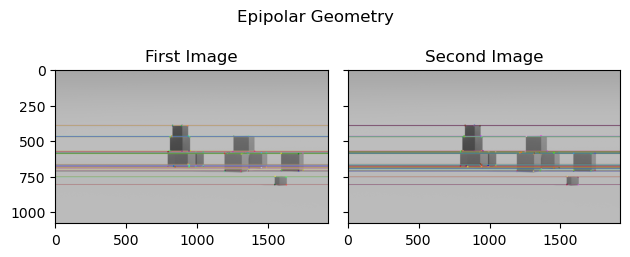

In [72]:
#F, mask = cv2.findFundamentalMat(pts1, pts2, cv2.RANSAC)
mask_pts_1 = pts1[mask.ravel()==1]
mask_pts_2 = pts2[mask.ravel()==1]
plot_epipolar_lines(im1_gray, im2_gray, pts1=mask_pts_1, pts2=mask_pts_2, F=F)

In [26]:
len(pts1)

937

In [80]:
import EightPoint
import importlib
importlib.reload(EightPoint)

EPA = EightPoint.EightPoint()
#F, consensus = EPA.getFundamentalRANSAC(pts1, pts2)

F_cv, mask = cv2.findFundamentalMat(pts1, pts2, cv2.RANSAC)

print(F_cv)

[[-1.83956216e-22  8.26674708e-18 -4.87231898e-15]
 [-8.18629689e-18  2.51406829e-21 -2.28942716e-02]
 [ 4.81591336e-15  2.28942716e-02  3.73034936e-14]]


In [28]:
#sum(abs(consensus-mask))
#consensus = np.expand_dims(consensus, axis=1)
print(sum(abs(consensus-mask)))

NameError: name 'consensus' is not defined

In [ ]:
F_from_mask = EPA.getFundementalLS(pts1[np.squeeze(mask)], pts2[np.squeeze(mask)])
print(F_from_mask)



[[-1.08381410e-05 -1.46715331e-05  1.80641339e-02]
 [ 1.60089779e-05  4.14672943e-07 -8.39131384e-03]
 [-8.29790535e-03  6.00150416e-03 -9.99749168e-01]]


In [76]:
print(F_cv)
print(compute_essential_matrix(F_cv, K))



[[-1.83956216e-22  8.26674708e-18 -4.87231898e-15]
 [-8.18629689e-18  2.51406829e-21 -2.28942716e-02]
 [ 4.81591336e-15  2.28942716e-02  3.73034936e-14]]
[[-1.30813309e-15  5.87857570e-11 -1.08920575e-12]
 [-5.82136668e-11  1.78778189e-14 -6.10513909e+01]
 [ 1.05369716e-12  6.10513909e+01  0.00000000e+00]]


In [78]:
R = np.eye(3)
T = [0.07537688314914703 * 1000, 0, 0]
Tx = np.cross(np.eye(3), T)

E = Tx @ R

print(f"E: {E}")

K = np.array([[2666.666666666, 0, 960],
            [0, 2666.666666666, 540],
            [0, 0, 1]]) 



F_actual=np.linalg.inv(K.T)@E@np.linalg.inv(K)
print(F_actual)


E: [[  0.           0.           0.        ]
 [  0.           0.         -75.37688315]
 [  0.          75.37688315   0.        ]]
[[ 0.          0.          0.        ]
 [ 0.          0.         -0.02826633]
 [ 0.          0.02826633  0.        ]]


## Correct 8-point

In [64]:
# Get normalizing matrix for a set of points
def __getNormalizingMatrix(pts):
    # Normalize points
    ptsMean = np.mean(pts, axis=0)
    ptsCentered = pts - ptsMean
    ptsStd = np.sqrt(np.sum(np.sum(ptsCentered ** 2, axis=1))/(2*len(pts)))
    M = np.array([[1/ptsStd, 0, 0],
                [0, 1/ptsStd, 0],
                [0, 0, 1]]) @ np.array([[1, 0, -ptsMean[0]],
                                        [0, 1, -ptsMean[1]],
                                        [0, 0, 1]])
    return M

masked_pts1= pts1[np.squeeze(mask)]
masked_pts2 = pts2[np.squeeze(mask)]

M1 = __getNormalizingMatrix(masked_pts1)
M2 = __getNormalizingMatrix(masked_pts2)

masked_pts1 = (M1 @ np.vstack((masked_pts1.T, np.ones((1, masked_pts1.shape[0]))))).T[:, 0:2]
masked_pts2 = (M2 @ np.vstack((masked_pts2.T, np.ones((1, masked_pts2.shape[0]))))).T[:, 0:2]

print(masked_pts1.shape)


F_masked_normalized, _ = cv2.findFundamentalMat(masked_pts1, masked_pts2, cv2.FM_8POINT)
F_masked = M2.T @ F_masked_normalized @ M1
print(F_masked/ F_masked[2,2])

masked_pts1_hom = np.hstack((masked_pts1, np.ones((masked_pts1.shape[0], 1))))
masked_pts2_hom = np.hstack((masked_pts2, np.ones((masked_pts2.shape[0], 1))))
error = np.abs(np.sum(masked_pts2_hom * (F_cv @ masked_pts1_hom.T).T, axis=1))
# np.abs(np.masked_pts1_hom @ (F_masked @ masked_pts2_hom.T), axis=1))


print(error)

(937, 2)
[[ 5.60748533e-06 -3.51150148e-06  2.35869852e-04]
 [-7.74764215e-06  6.10704715e-06 -1.36149017e-03]
 [ 3.74677352e-03 -3.36744049e-03  1.00000000e+00]]
[5.41515722e+09 9.83326936e+08 5.41515722e+09 5.41515722e+09
 9.83326936e+08 5.41515722e+09 9.83326936e+08 5.41515722e+09
 9.83326936e+08 9.83326936e+08 9.83326936e+08 9.83326936e+08
 9.83326936e+08 9.83326936e+08 9.83326936e+08 9.83326936e+08
 9.83326936e+08 9.83326936e+08 9.83326936e+08 9.83326936e+08
 9.83326936e+08 9.83326936e+08 9.83326936e+08 5.41515722e+09
 9.83326936e+08 9.83326936e+08 5.41515722e+09 5.41515722e+09
 9.83326936e+08 5.41515722e+09 9.83326936e+08 9.83326936e+08
 9.83326936e+08 9.83326936e+08 5.41515722e+09 5.41515722e+09
 5.41515722e+09 5.41515722e+09 9.83326936e+08 5.41515722e+09
 9.83326936e+08 9.83326936e+08 9.83326936e+08 9.83326936e+08
 9.83326936e+08 9.83326936e+08 9.83326936e+08 9.83326936e+08
 9.83326936e+08 9.83326936e+08 9.83326936e+08 5.41515722e+09
 9.83326936e+08 9.83326936e+08 5.41515722e+0